### Load package

In [ ]:
# Install package first
# We use uv for faster installation
!pip install uv
!uv pip install -q autogluon.timeseries --system
!uv pip uninstall -q torchaudio torchvision torchtext --system # fix incompatible package versions on Colab

## if there seems to be inconsistency due to numpy & pandas versions, do the following
!uv pip uninstall pandas numpy
!uv pip install -q --force-reinstall numpy==1.26.4 --system
!uv pip install -q --force-reinstall pandas==2.2.2 --system
## You may need to restart colab kernel

Using Python 3.11.11 environment at: /usr
Uninstalled 2 packages in 418ms
 - numpy==1.26.4
 - pandas==2.2.2


In [ ]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.common import space

In [2]:
import numpy as np
import pandas as pd
import os
import re

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting

/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting


**Regarding Forecasting/prediction Length:**
- Data length<180: prediction length=24
- 180<Data length<300: prediction length = 36
- 300<Data length<1000: prediction length = 48
- Data length>=1000: prediction length = 100

## Fine-tuned Forecasting for 20 time series from PdM_telemetry

In [ ]:
# Define input Excel file and existing leaderboard
file_path = "/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/Chronos_PdM_forecasting_reformat.xlsx"
leaderboard_file = "/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/Chronos_Forecasting_Finetuned_Leaderboard.xlsx"

# Load all sheets
all_series = pd.read_excel(file_path, sheet_name=None, parse_dates=True)

# Load existing leaderboard
if os.path.exists(leaderboard_file):
    existing_leaderboard = pd.read_excel(leaderboard_file)
    leaderboard_results = [existing_leaderboard]
else:
    leaderboard_results = []

In [ ]:
# Extract data length from sheet name
def get_data_length(sheet_name):
    match = re.search(r'_(\d+)$', sheet_name)
    if match:
        return int(match.group(1))
    else:
        raise ValueError(f"Cannot extract data length from sheet name: {sheet_name}")

# Determine prediction length from data length
def get_prediction_length(data_length):
    if data_length < 180:
        return 24
    elif data_length < 300:
        return 36
    elif data_length < 1000:
        return 48
    else:
        return 100

In [ ]:
# Select model and tuning config
def get_model_hyperparams(data_length):
    if data_length <= 500:
        model = "bolt_tiny"
        hyper = {
            "Chronos": [
                {"model_path": model, "ag_args": {"name_suffix": "ZeroShot"}},
                {"model_path": model, "fine_tune": True,
                 "fine_tune_lr": space.Real(0.000001, 0.001, log=True),
                 "fine_tune_steps": space.Categorical(125, 250, 500, 1000),
                 "fine_tune_batch_size": space.Categorical(16, 32, 64),
                 "ag_args": {"name_suffix": "FineTuned"}}
            ]
        }
        time = 400
    elif data_length <= 1500:
        model = "bolt_mini"
        hyper = {
            "Chronos": [
                {"model_path": model, "ag_args": {"name_suffix": "ZeroShot"}},
                {"model_path": model, "fine_tune": True,
                 "fine_tune_lr": space.Real(0.00001, 0.0001, log=True),
                 "fine_tune_steps": space.Categorical(125, 250, 500, 1000),
                 "fine_tune_batch_size": space.Categorical(16, 32, 64),
                 "ag_args": {"name_suffix": "FineTuned"}}
            ]
        }
        time = 500
    elif data_length <= 5000:
        model = "bolt_small"
        hyper = {
            "Chronos": [
                {"model_path": model, "ag_args": {"name_suffix": "ZeroShot"}},
                {"model_path": model, "fine_tune": True,
                 "fine_tune_lr": space.Real(0.00001, 0.0001, log=True),
                 "fine_tune_steps": space.Categorical(500, 1000),
                 "fine_tune_batch_size": space.Categorical(16, 32, 64),
                 "ag_args": {"name_suffix": "FineTuned"}}
            ]
        }
        time = 700
    else:
        model = "bolt_base"
        hyper = {
            "Chronos": [
                {"model_path": model, "ag_args": {"name_suffix": "ZeroShot"}},
                {"model_path": model, "fine_tune": True,
                 "fine_tune_lr": space.Real(0.00001, 0.0001, log=True),
                 "fine_tune_steps": space.Categorical(500, 1000),
                 "fine_tune_batch_size": space.Categorical(16, 32, 64),
                 "ag_args": {"name_suffix": "FineTuned"}}
            ]
        }
        time = 900
    return model, hyper, time

In [ ]:
# Process all sheets
for sheet_name, df in all_series.items():
    print(f"Processing {sheet_name}")

    data_length = get_data_length(sheet_name)
    prediction_length = get_prediction_length(data_length)
    model_name, hyperparams, time_limit = get_model_hyperparams(data_length)

    # Convert to TimeSeriesDataFrame
    data = TimeSeriesDataFrame.from_data_frame(df)

    # Train-test split
    train_data, test_data = data.train_test_split(prediction_length)

    # Train model
    predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
        train_data=train_data,
        hyperparameters=hyperparams,
        hyperparameter_tune_kwargs="auto",
        time_limit=time_limit
    )

    # Evaluate
    predictions = predictor.predict(train_data)
    leaderboard_df = predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAPE', 'MAE', 'MSE', 'RMSE', 'MASE'])
    leaderboard_df.insert(0, 'time_series', sheet_name)
    leaderboard_results.append(leaderboard_df)

# Save final leaderboard
leaderboard_final = pd.concat(leaderboard_results, ignore_index=True)
leaderboard_final.to_excel(leaderboard_file, index=False)

print("All sheets processed and results appended to:", leaderboard_file)

Beginning AutoGluon training... Time limit = 400s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_120727'


Processing volt_200


=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       11.11 GB / 12.67 GB (87.6%)
Disk Space Avail:   61.73 GB / 107.72 GB (57.3%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_tiny'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64],
                                  'fine_tune_lr': Real: lower=1e-06, upper=0.001,
                                  'fine_tune_steps': Categorical[125, 250, 500, 1000],
   

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/34.6M [00:00<?, ?B/s]

	-0.0500       = Validation score (-WQL)
	21.72   s     = Training runtime
	1.37    s     = Validation (prediction) runtime
Hyperparameter tuning model ChronosFineTuned[bolt_tiny]. Tuning model for up to 185.5s of the 370.9s remaining.
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_120727/models/ChronosFineTuned[bolt_tiny]/T1/W0/fine-tuned-ckpt
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_120727/models/ChronosFineTuned[bolt_tiny]/T2/W0/fine-tuned-ckpt
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_120727/model

Processing volt_500


	-0.1009       = Validation score (-WQL)
	0.01    s     = Training runtime
	0.29    s     = Validation (prediction) runtime
Hyperparameter tuning model ChronosFineTuned[bolt_tiny]. Tuning model for up to 199.8s of the 399.6s remaining.
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_121041/models/ChronosFineTuned[bolt_tiny]/T1/W0/fine-tuned-ckpt
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_121041/models/ChronosFineTuned[bolt_tiny]/T2/W0/fine-tuned-ckpt
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_121041/model

Processing volt_2000


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/191M [00:00<?, ?B/s]

	-0.0580       = Validation score (-WQL)
	0.02    s     = Training runtime
	2.63    s     = Validation (prediction) runtime
Hyperparameter tuning model ChronosFineTuned[bolt_small]. Tuning model for up to 348.6s of the 697.2s remaining.
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_121346/models/ChronosFineTuned[bolt_small]/T1/W0/fine-tuned-ckpt
	Trained 1 models while tuning ChronosFineTuned[bolt_small].
	-0.0560       = Validation score (-WQL)
	285.15  s     = Total tuning time
Fitting simple weighted ensemble.
	Ensemble weights: {'ChronosFineTuned[bolt_small]/T1': np.float64(1.0)}
	-0.0560       = Validation score (-WQL)
	0.25    s     = Training runtime
	0.33    s     = Validation (prediction) runtime
Training complete. Models trained: ['ChronosZeroShot[bolt_small]', 'ChronosFineTuned[bolt_small]/T1', 'WeightedEnsemble']
T

Processing volt_5000


	-0.0562       = Validation score (-WQL)
	0.02    s     = Training runtime
	0.60    s     = Validation (prediction) runtime
Hyperparameter tuning model ChronosFineTuned[bolt_small]. Tuning model for up to 349.6s of the 699.3s remaining.
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_121836/models/ChronosFineTuned[bolt_small]/T1/W0/fine-tuned-ckpt
	Trained 1 models while tuning ChronosFineTuned[bolt_small].
	-0.0546       = Validation score (-WQL)
	283.92  s     = Total tuning time
Fitting simple weighted ensemble.
	Ensemble weights: {'ChronosFineTuned[bolt_small]/T1': np.float64(1.0)}
	-0.0546       = Validation score (-WQL)
	0.25    s     = Training runtime
	0.43    s     = Validation (prediction) runtime
Training complete. Models trained: ['ChronosZeroShot[bolt_small]', 'ChronosFineTuned[bolt_small]/T1', 'WeightedEnsemble']
T

Processing volt_8761


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/821M [00:00<?, ?B/s]

	-0.0609       = Validation score (-WQL)
	0.02    s     = Training runtime
	12.62   s     = Validation (prediction) runtime
Hyperparameter tuning model ChronosFineTuned[bolt_base]. Tuning model for up to 443.6s of the 887.3s remaining.
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_122323/models/ChronosFineTuned[bolt_base]/T1/W0/fine-tuned-ckpt
	Trained 1 models while tuning ChronosFineTuned[bolt_base].
	-0.0605       = Validation score (-WQL)
	365.83  s     = Total tuning time
Fitting simple weighted ensemble.
	Ensemble weights: {'ChronosFineTuned[bolt_base]/T1': np.float64(1.0)}
	-0.0605       = Validation score (-WQL)
	0.33    s     = Training runtime
	1.08    s     = Validation (prediction) runtime
Training complete. Models trained: ['ChronosZeroShot[bolt_base]', 'ChronosFineTuned[bolt_base]/T1', 'WeightedEnsemble']
Total r

Processing rotate_200


	-0.0622       = Validation score (-WQL)
	0.02    s     = Training runtime
	0.30    s     = Validation (prediction) runtime
Hyperparameter tuning model ChronosFineTuned[bolt_tiny]. Tuning model for up to 199.8s of the 399.6s remaining.
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_122948/models/ChronosFineTuned[bolt_tiny]/T1/W0/fine-tuned-ckpt
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_122948/models/ChronosFineTuned[bolt_tiny]/T2/W0/fine-tuned-ckpt
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_122948/model

Processing rotate_500


	-0.0598       = Validation score (-WQL)
	0.01    s     = Training runtime
	0.30    s     = Validation (prediction) runtime
Hyperparameter tuning model ChronosFineTuned[bolt_tiny]. Tuning model for up to 199.8s of the 399.6s remaining.
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_123243/models/ChronosFineTuned[bolt_tiny]/T1/W0/fine-tuned-ckpt
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_123243/models/ChronosFineTuned[bolt_tiny]/T2/W0/fine-tuned-ckpt
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_123243/model

Processing rotate_2000


	-0.0807       = Validation score (-WQL)
	0.01    s     = Training runtime
	0.62    s     = Validation (prediction) runtime
Hyperparameter tuning model ChronosFineTuned[bolt_small]. Tuning model for up to 349.6s of the 699.3s remaining.
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_123546/models/ChronosFineTuned[bolt_small]/T1/W0/fine-tuned-ckpt
	Trained 1 models while tuning ChronosFineTuned[bolt_small].
	-0.0797       = Validation score (-WQL)
	285.51  s     = Total tuning time
Fitting simple weighted ensemble.
	Ensemble weights: {'ChronosFineTuned[bolt_small]/T1': np.float64(1.0)}
	-0.0797       = Validation score (-WQL)
	0.25    s     = Training runtime
	0.27    s     = Validation (prediction) runtime
Training complete. Models trained: ['ChronosZeroShot[bolt_small]', 'ChronosFineTuned[bolt_small]/T1', 'WeightedEnsemble']
T

Processing rotate_5000


	-0.0706       = Validation score (-WQL)
	0.04    s     = Training runtime
	0.82    s     = Validation (prediction) runtime
Hyperparameter tuning model ChronosFineTuned[bolt_small]. Tuning model for up to 349.5s of the 699.0s remaining.
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_124035/models/ChronosFineTuned[bolt_small]/T1/W0/fine-tuned-ckpt
	Trained 1 models while tuning ChronosFineTuned[bolt_small].
	-0.0693       = Validation score (-WQL)
	286.07  s     = Total tuning time
Fitting simple weighted ensemble.
	Ensemble weights: {'ChronosFineTuned[bolt_small]/T1': np.float64(1.0)}
	-0.0693       = Validation score (-WQL)
	0.28    s     = Training runtime
	0.32    s     = Validation (prediction) runtime
Training complete. Models trained: ['ChronosZeroShot[bolt_small]', 'ChronosFineTuned[bolt_small]/T1', 'WeightedEnsemble']
T

Processing rotate_8761


	-0.0695       = Validation score (-WQL)
	0.02    s     = Training runtime
	1.78    s     = Validation (prediction) runtime
Hyperparameter tuning model ChronosFineTuned[bolt_base]. Tuning model for up to 449.0s of the 898.1s remaining.
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_124525/models/ChronosFineTuned[bolt_base]/T1/W0/fine-tuned-ckpt
	Trained 1 models while tuning ChronosFineTuned[bolt_base].
	-0.0693       = Validation score (-WQL)
	382.70  s     = Total tuning time
Fitting simple weighted ensemble.
	Ensemble weights: {'ChronosFineTuned[bolt_base]/T1': np.float64(0.68), 'ChronosZeroShot[bolt_base]': np.float64(0.32)}
	-0.0693       = Validation score (-WQL)
	0.24    s     = Training runtime
	2.85    s     = Validation (prediction) runtime
Training complete. Models trained: ['ChronosZeroShot[bolt_base]', 'ChronosFine

Processing pressure_200


	-0.0671       = Validation score (-WQL)
	0.01    s     = Training runtime
	0.35    s     = Validation (prediction) runtime
Hyperparameter tuning model ChronosFineTuned[bolt_tiny]. Tuning model for up to 199.8s of the 399.5s remaining.
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_125155/models/ChronosFineTuned[bolt_tiny]/T1/W0/fine-tuned-ckpt
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_125155/models/ChronosFineTuned[bolt_tiny]/T2/W0/fine-tuned-ckpt
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_125155/model

Processing pressure_500


	-0.0755       = Validation score (-WQL)
	0.02    s     = Training runtime
	0.41    s     = Validation (prediction) runtime
Hyperparameter tuning model ChronosFineTuned[bolt_tiny]. Tuning model for up to 199.7s of the 399.4s remaining.
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_125453/models/ChronosFineTuned[bolt_tiny]/T1/W0/fine-tuned-ckpt
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_125453/models/ChronosFineTuned[bolt_tiny]/T2/W0/fine-tuned-ckpt
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_125453/model

Processing pressure_2000


	-0.0642       = Validation score (-WQL)
	0.02    s     = Training runtime
	0.61    s     = Validation (prediction) runtime
Hyperparameter tuning model ChronosFineTuned[bolt_small]. Tuning model for up to 349.6s of the 699.3s remaining.
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_125756/models/ChronosFineTuned[bolt_small]/T1/W0/fine-tuned-ckpt
	Trained 1 models while tuning ChronosFineTuned[bolt_small].
	-0.0626       = Validation score (-WQL)
	286.03  s     = Total tuning time
Fitting simple weighted ensemble.
	Ensemble weights: {'ChronosFineTuned[bolt_small]/T1': np.float64(1.0)}
	-0.0626       = Validation score (-WQL)
	0.24    s     = Training runtime
	0.25    s     = Validation (prediction) runtime
Training complete. Models trained: ['ChronosZeroShot[bolt_small]', 'ChronosFineTuned[bolt_small]/T1', 'WeightedEnsemble']
T

Processing pressure_5000


	-0.0550       = Validation score (-WQL)
	0.02    s     = Training runtime
	0.64    s     = Validation (prediction) runtime
Hyperparameter tuning model ChronosFineTuned[bolt_small]. Tuning model for up to 349.6s of the 699.2s remaining.
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_130246/models/ChronosFineTuned[bolt_small]/T1/W0/fine-tuned-ckpt
	Trained 1 models while tuning ChronosFineTuned[bolt_small].
	-0.0543       = Validation score (-WQL)
	284.52  s     = Total tuning time
Fitting simple weighted ensemble.
	Ensemble weights: {'ChronosFineTuned[bolt_small]/T1': np.float64(1.0)}
	-0.0543       = Validation score (-WQL)
	0.25    s     = Training runtime
	0.31    s     = Validation (prediction) runtime
Training complete. Models trained: ['ChronosZeroShot[bolt_small]', 'ChronosFineTuned[bolt_small]/T1', 'WeightedEnsemble']
T

Processing pressure_8761


	-0.0702       = Validation score (-WQL)
	0.02    s     = Training runtime
	2.09    s     = Validation (prediction) runtime
Hyperparameter tuning model ChronosFineTuned[bolt_base]. Tuning model for up to 448.9s of the 897.8s remaining.
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_130733/models/ChronosFineTuned[bolt_base]/T1/W0/fine-tuned-ckpt
	Trained 1 models while tuning ChronosFineTuned[bolt_base].
	-0.0703       = Validation score (-WQL)
	377.21  s     = Total tuning time
Fitting simple weighted ensemble.
	Ensemble weights: {'ChronosFineTuned[bolt_base]/T1': np.float64(0.25), 'ChronosZeroShot[bolt_base]': np.float64(0.75)}
	-0.0702       = Validation score (-WQL)
	0.40    s     = Training runtime
	3.80    s     = Validation (prediction) runtime
Training complete. Models trained: ['ChronosZeroShot[bolt_base]', 'ChronosFine

Processing vibration_200


	-0.0918       = Validation score (-WQL)
	0.02    s     = Training runtime
	0.31    s     = Validation (prediction) runtime
Hyperparameter tuning model ChronosFineTuned[bolt_tiny]. Tuning model for up to 199.8s of the 399.5s remaining.
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_131358/models/ChronosFineTuned[bolt_tiny]/T1/W0/fine-tuned-ckpt
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_131358/models/ChronosFineTuned[bolt_tiny]/T2/W0/fine-tuned-ckpt
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_131358/model

Processing vibration_500


	-0.1091       = Validation score (-WQL)
	0.02    s     = Training runtime
	0.29    s     = Validation (prediction) runtime
Hyperparameter tuning model ChronosFineTuned[bolt_tiny]. Tuning model for up to 199.8s of the 399.6s remaining.
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_131654/models/ChronosFineTuned[bolt_tiny]/T1/W0/fine-tuned-ckpt
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_131654/models/ChronosFineTuned[bolt_tiny]/T2/W0/fine-tuned-ckpt
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_131654/model

Processing vibration_2000


	-0.0973       = Validation score (-WQL)
	0.02    s     = Training runtime
	0.62    s     = Validation (prediction) runtime
Hyperparameter tuning model ChronosFineTuned[bolt_small]. Tuning model for up to 349.6s of the 699.3s remaining.
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_131957/models/ChronosFineTuned[bolt_small]/T1/W0/fine-tuned-ckpt
	Trained 1 models while tuning ChronosFineTuned[bolt_small].
	-0.0959       = Validation score (-WQL)
	287.01  s     = Total tuning time
Fitting simple weighted ensemble.
	Ensemble weights: {'ChronosFineTuned[bolt_small]/T1': np.float64(1.0)}
	-0.0959       = Validation score (-WQL)
	0.23    s     = Training runtime
	0.27    s     = Validation (prediction) runtime
Training complete. Models trained: ['ChronosZeroShot[bolt_small]', 'ChronosFineTuned[bolt_small]/T1', 'WeightedEnsemble']
T

Processing vibration_5000


	-0.0830       = Validation score (-WQL)
	0.02    s     = Training runtime
	0.60    s     = Validation (prediction) runtime
Hyperparameter tuning model ChronosFineTuned[bolt_small]. Tuning model for up to 349.6s of the 699.3s remaining.
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_132447/models/ChronosFineTuned[bolt_small]/T1/W0/fine-tuned-ckpt
	Trained 1 models while tuning ChronosFineTuned[bolt_small].
	-0.0807       = Validation score (-WQL)
	293.07  s     = Total tuning time
Fitting simple weighted ensemble.
	Ensemble weights: {'ChronosFineTuned[bolt_small]/T1': np.float64(1.0)}
	-0.0807       = Validation score (-WQL)
	0.23    s     = Training runtime
	0.28    s     = Validation (prediction) runtime
Training complete. Models trained: ['ChronosZeroShot[bolt_small]', 'ChronosFineTuned[bolt_small]/T1', 'WeightedEnsemble']
T

Processing vibration_8761


	-0.0827       = Validation score (-WQL)
	0.02    s     = Training runtime
	1.58    s     = Validation (prediction) runtime
Hyperparameter tuning model ChronosFineTuned[bolt_base]. Tuning model for up to 449.1s of the 898.3s remaining.
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_132943/models/ChronosFineTuned[bolt_base]/T1/W0/fine-tuned-ckpt
	Trained 1 models while tuning ChronosFineTuned[bolt_base].
	-0.0810       = Validation score (-WQL)
	370.37  s     = Total tuning time
Fitting simple weighted ensemble.
	Ensemble weights: {'ChronosFineTuned[bolt_base]/T1': np.float64(1.0)}
	-0.0810       = Validation score (-WQL)
	0.26    s     = Training runtime
	1.07    s     = Validation (prediction) runtime
Training complete. Models trained: ['ChronosZeroShot[bolt_base]', 'ChronosFineTuned[bolt_base]/T1', 'WeightedEnsemble']
Total r

All sheets processed and results appended to: /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/Chronos_Forecasting_Finetuned_Leaderboard.xlsx


## Fine-tuned Forecasting for 80 time series from other data sources

In [ ]:
# Function to extract data length
def get_data_length(file_name):
    match = re.search(r'_(\d+)\.csv$', file_name)
    if match:
        return int(match.group(1))
    else:
        raise ValueError(f"Cannot extract data length from file name: {file_name}")

# Function to determine prediction length
def get_prediction_length(length):
    if length < 180:
        return 24
    elif length < 300:
        return 36
    elif length < 1000:
        return 48
    else:
        return 100

In [ ]:
# Define directories
input_dir = "/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/Chronos Forecasting Data Reformat/"
leaderboard_file = "/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/Chronos_Forecasting_Finetuned_Leaderboard.xlsx"

# Files that require manual frequency specification
weekly_freq_files = {
    "reform_ILINetDataset_DARTS_%WEIGHTED_ILI_1041.csv",
    "reform_ILINetDataset_DARTS_age0to4_1041.csv",
    "reform_ILINetDataset_DARTS_age5to24_1041.csv",
    "reform_ILINetDataset_DARTS_age25to49_677.csv",
    "reform_ILINetDataset_DARTS_age25to64_364.csv",
    "reform_ILINetDataset_DARTS_age50to64_677.csv",
    "reform_ILINetDataset_DARTS_age65_1041.csv",
    "reform_ILINetDataset_DARTS_illtotal_1041.csv",
    "reform_ILINetDataset_DARTS_num_provider_1041.csv",
    "reform_ILINetDataset_DARTS_total_patient_1041.csv",
    "reform_USGasolineDataset_DARTS_1578.csv"
}

daily_freq_files = {
    "reform_TemperatureDataset_DARTS_3650.csv",
    "reform_TemperatureDataset_DARTS_200.csv",
    "reform_TemperatureDataset_DARTS_500.csv",
    "reform_TemperatureDataset_DARTS_2000.csv"
}

half_second_freq_file = "reform_HeartRateDataset_DARTS_1800.csv"

# Get all CSV files in the input directory
csv_files = [f for f in os.listdir(input_dir) if f.endswith('.csv')]

# Load existing leaderboard data
if os.path.exists(leaderboard_file):
    existing_leaderboard = pd.read_excel(leaderboard_file)
    leaderboard_results = [existing_leaderboard]
else:
    leaderboard_results = []

In [ ]:
for file in csv_files:
    print(f"Processing {file}")
    print("=" * 40)

    file_path = os.path.join(input_dir, file)
    df = pd.read_csv(file_path)
    df.columns = ['item_id', 'timestamp', 'target']
    data = TimeSeriesDataFrame.from_data_frame(df)

    # Get data length and prediction length
    data_length = get_data_length(file)
    prediction_length = get_prediction_length(data_length)

    # Split into train/test
    train_data, test_data = data.train_test_split(prediction_length=prediction_length)

    # Determine frequency
    if file in weekly_freq_files:
        freq = 'W'
    elif file in daily_freq_files:
        freq = 'D'
    elif file == half_second_freq_file:
        freq = '500ms'
    else:
        freq = None

    # Define model and hyperparameters based on data length
    if data_length <= 500:
        model = "bolt_tiny"
        hyperparameters = {
            "Chronos": [
                {"model_path": model, "ag_args": {"name_suffix": "ZeroShot"}},
                {"model_path": model, "fine_tune": True,
                 "fine_tune_lr": space.Real(0.000001, 0.001, log=True),
                 "fine_tune_steps": space.Categorical(125, 250, 500, 1000),
                 "fine_tune_batch_size": space.Categorical(16, 32, 64),
                 "ag_args": {"name_suffix": "FineTuned"}}
            ]
        }
        time_limit = 400
    elif data_length <= 1500:
        model = "bolt_mini"
        hyperparameters = {
            "Chronos": [
                {"model_path": model, "ag_args": {"name_suffix": "ZeroShot"}},
                {"model_path": model, "fine_tune": True,
                 "fine_tune_lr": space.Real(0.00001, 0.0001, log=True),
                 "fine_tune_steps": space.Categorical(125, 250, 500, 1000),
                 "fine_tune_batch_size": space.Categorical(16, 32, 64),
                 "ag_args": {"name_suffix": "FineTuned"}}
            ]
        }
        time_limit = 500
    elif data_length <= 5000:
        model = "bolt_small"
        hyperparameters = {
            "Chronos": [
                {"model_path": model, "ag_args": {"name_suffix": "ZeroShot"}},
                {"model_path": model, "fine_tune": True,
                 "fine_tune_lr": space.Real(0.00001, 0.0001, log=True),
                 "fine_tune_steps": space.Categorical(500, 1000),
                 "fine_tune_batch_size": space.Categorical(16, 32, 64),
                 "ag_args": {"name_suffix": "FineTuned"}}
            ]
        }
        time_limit = 700
    else:
        model = "bolt_base"
        hyperparameters = {
            "Chronos": [
                {"model_path": model, "ag_args": {"name_suffix": "ZeroShot"}},
                {"model_path": model, "fine_tune": True,
                 "fine_tune_lr": space.Real(0.00001, 0.0001, log=True),
                 "fine_tune_steps": space.Categorical(500, 1000),
                 "fine_tune_batch_size": space.Categorical(16, 32, 64),
                 "ag_args": {"name_suffix": "FineTuned"}}
            ]
        }
        time_limit = 900

    # Initialize and fit the predictor
    if freq:
        predictor = TimeSeriesPredictor(prediction_length=prediction_length, freq=freq).fit(
            train_data=train_data,
            hyperparameters=hyperparameters,
            hyperparameter_tune_kwargs="auto",
            time_limit=time_limit
        )
    else:
        predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
            train_data=train_data,
            hyperparameters=hyperparameters,
            hyperparameter_tune_kwargs="auto",
            time_limit=time_limit
        )

    # Predict and evaluate
    predictions = predictor.predict(train_data)
    leaderboard_df = predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAPE', 'MAE', 'MSE', 'RMSE', 'MASE'])
    leaderboard_df.insert(0, 'time_series', file.replace('.csv', ''))
    leaderboard_results.append(leaderboard_df)

# Save leaderboard results
leaderboard_results_df = pd.concat(leaderboard_results, ignore_index=True)
leaderboard_results_df.to_excel(leaderboard_file, index=False)

print("Processing complete. Results saved to:", leaderboard_file)

Beginning AutoGluon training... Time limit = 400s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250331_235747'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.33 GB / 12.67 GB (81.5%)
Disk Space Avail:   61.59 GB / 107.72 GB (57.2%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_tiny'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64

Processing reform_MonthlyMilkDataset_DARTS_168.csv


	-0.0294       = Validation score (-WQL)
	0.01    s     = Training runtime
	1.00    s     = Validation (prediction) runtime
Hyperparameter tuning model ChronosFineTuned[bolt_tiny]. Tuning model for up to 199.4s of the 398.9s remaining.
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250331_235747/models/ChronosFineTuned[bolt_tiny]/T1/W0/fine-tuned-ckpt
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250331_235747/models/ChronosFineTuned[bolt_tiny]/T2/W0/fine-tuned-ckpt
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250331_235747/model

Processing reform_HeaterDataset_DARTS_198.csv


Beginning AutoGluon training... Time limit = 400s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_000046'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.39 GB / 12.67 GB (82.0%)
Disk Space Avail:   61.53 GB / 107.72 GB (57.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_tiny'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64

Processing reform_AirPassengersDataset_DARTS_144.csv


Beginning AutoGluon training... Time limit = 400s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_000346'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.44 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.43 GB / 107.72 GB (57.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_tiny'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64

Processing reform_IceCreamDataset_DARTS_198.csv


Beginning AutoGluon training... Time limit = 400s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_000644'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.41 GB / 12.67 GB (82.1%)
Disk Space Avail:   61.34 GB / 107.72 GB (56.9%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_tiny'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64

Processing reform_ILINetDataset_DARTS_age25to64_364.csv


Frequency 'W' stored as 'W-SUN'
Beginning AutoGluon training... Time limit = 400s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_000945'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.39 GB / 12.67 GB (81.9%)
Disk Space Avail:   61.25 GB / 107.72 GB (56.9%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'W-SUN',
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_tiny'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                              

Processing reform_ILINetDataset_DARTS_%WEIGHTED_ILI_1041.csv


Frequency 'W' stored as 'W-SUN'
Beginning AutoGluon training... Time limit = 500s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_001251'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.24 GB / 12.67 GB (80.8%)
Disk Space Avail:   61.15 GB / 107.72 GB (56.8%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'W-SUN',
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_mini'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                              

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/85.0M [00:00<?, ?B/s]

	-0.2562       = Validation score (-WQL)
	0.02    s     = Training runtime
	5.23    s     = Validation (prediction) runtime
Hyperparameter tuning model ChronosFineTuned[bolt_mini]. Tuning model for up to 247.3s of the 494.6s remaining.
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_001251/models/ChronosFineTuned[bolt_mini]/T1/W0/fine-tuned-ckpt
	Trained 1 models while tuning ChronosFineTuned[bolt_mini].
	-0.2494       = Validation score (-WQL)
	179.12  s     = Total tuning time
Fitting simple weighted ensemble.
	Ensemble weights: {'ChronosFineTuned[bolt_mini]/T1': np.float64(0.95), 'ChronosZeroShot[bolt_mini]': np.float64(0.05)}
	-0.2494       = Validation score (-WQL)
	0.26    s     = Training runtime
	5.33    s     = Validation (prediction) runtime
Training complete. Models trained: ['ChronosZeroShot[bolt_mini]', 'ChronosFine

Processing reform_TemperatureDataset_DARTS_3650.csv


Beginning AutoGluon training... Time limit = 700s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_001558'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.97 GB / 12.67 GB (78.7%)
Disk Space Avail:   61.00 GB / 107.72 GB (56.6%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'D',
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categori

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/191M [00:00<?, ?B/s]

	-0.1996       = Validation score (-WQL)
	0.02    s     = Training runtime
	3.21    s     = Validation (prediction) runtime
Hyperparameter tuning model ChronosFineTuned[bolt_small]. Tuning model for up to 348.3s of the 696.7s remaining.
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_001558/models/ChronosFineTuned[bolt_small]/T1/W0/fine-tuned-ckpt
	Trained 1 models while tuning ChronosFineTuned[bolt_small].
	-0.1895       = Validation score (-WQL)
	284.38  s     = Total tuning time
Fitting simple weighted ensemble.
	Ensemble weights: {'ChronosFineTuned[bolt_small]/T1': np.float64(1.0)}
	-0.1895       = Validation score (-WQL)
	0.24    s     = Training runtime
	0.29    s     = Validation (prediction) runtime
Training complete. Models trained: ['ChronosZeroShot[bolt_small]', 'ChronosFineTuned[bolt_small]/T1', 'WeightedEnsemble']
T

Processing reform_SunspotsDataset_DARTS_2820.csv


Beginning AutoGluon training... Time limit = 700s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_002051'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.16 GB / 12.67 GB (72.3%)
Disk Space Avail:   60.66 GB / 107.72 GB (56.3%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64

Processing reform_ILINetDataset_DARTS_age0to4_1041.csv


Frequency 'W' stored as 'W-SUN'
Beginning AutoGluon training... Time limit = 500s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_002544'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.17 GB / 12.67 GB (72.3%)
Disk Space Avail:   60.49 GB / 107.72 GB (56.2%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'W-SUN',
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_mini'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                               

Processing reform_ILINetDataset_DARTS_age5to24_1041.csv


Frequency 'W' stored as 'W-SUN'
Beginning AutoGluon training... Time limit = 500s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_002834'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.20 GB / 12.67 GB (72.6%)
Disk Space Avail:   60.41 GB / 107.72 GB (56.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'W-SUN',
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_mini'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                               

Processing reform_ILINetDataset_DARTS_age25to49_677.csv


Frequency 'W' stored as 'W-SUN'
Beginning AutoGluon training... Time limit = 500s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_003125'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.22 GB / 12.67 GB (72.7%)
Disk Space Avail:   60.34 GB / 107.72 GB (56.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'W-SUN',
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_mini'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                               

Processing reform_ILINetDataset_DARTS_illtotal_1041.csv


Frequency 'W' stored as 'W-SUN'
Beginning AutoGluon training... Time limit = 500s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_003337'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.22 GB / 12.67 GB (72.7%)
Disk Space Avail:   60.26 GB / 107.72 GB (55.9%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'W-SUN',
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_mini'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                               

Processing reform_ILINetDataset_DARTS_age50to64_677.csv


Frequency 'W' stored as 'W-SUN'
Beginning AutoGluon training... Time limit = 500s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_003630'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.24 GB / 12.67 GB (72.9%)
Disk Space Avail:   60.19 GB / 107.72 GB (55.9%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'W-SUN',
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_mini'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                               

Processing reform_ILINetDataset_DARTS_age65_1041.csv


Frequency 'W' stored as 'W-SUN'
Beginning AutoGluon training... Time limit = 500s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_004022'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.22 GB / 12.67 GB (72.7%)
Disk Space Avail:   60.03 GB / 107.72 GB (55.7%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'W-SUN',
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_mini'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                               

Processing reform_ILINetDataset_DARTS_total_patient_1041.csv


Frequency 'W' stored as 'W-SUN'
Beginning AutoGluon training... Time limit = 500s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_004313'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.25 GB / 12.67 GB (73.0%)
Disk Space Avail:   59.96 GB / 107.72 GB (55.7%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'W-SUN',
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_mini'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                               

Processing reform_ExchangeRateDataset_DARTS_aus_7588.csv


Beginning AutoGluon training... Time limit = 900s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_004609'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.24 GB / 12.67 GB (72.9%)
Disk Space Avail:   59.88 GB / 107.72 GB (55.6%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/821M [00:00<?, ?B/s]

	-0.0142       = Validation score (-WQL)
	0.02    s     = Training runtime
	16.84   s     = Validation (prediction) runtime
Hyperparameter tuning model ChronosFineTuned[bolt_base]. Tuning model for up to 441.5s of the 883.0s remaining.
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_004609/models/ChronosFineTuned[bolt_base]/T1/W0/fine-tuned-ckpt
	Trained 1 models while tuning ChronosFineTuned[bolt_base].
	-0.0123       = Validation score (-WQL)
	384.34  s     = Total tuning time
Fitting simple weighted ensemble.
	Ensemble weights: {'ChronosFineTuned[bolt_base]/T1': np.float64(1.0)}
	-0.0123       = Validation score (-WQL)
	0.24    s     = Training runtime
	1.11    s     = Validation (prediction) runtime
Training complete. Models trained: ['ChronosZeroShot[bolt_base]', 'ChronosFineTuned[bolt_base]/T1', 'WeightedEnsemble']
Total r

Processing reform_ILINetDataset_DARTS_num_provider_1041.csv


Frequency 'W' stored as 'W-SUN'
Beginning AutoGluon training... Time limit = 500s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_005257'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       7.29 GB / 12.67 GB (57.5%)
Disk Space Avail:   58.43 GB / 107.72 GB (54.2%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'W-SUN',
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_mini'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                               

Processing reform_ExchangeRateDataset_DARTS_brt_7588.csv


Beginning AutoGluon training... Time limit = 900s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_005550'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       8.26 GB / 12.67 GB (65.2%)
Disk Space Avail:   58.35 GB / 107.72 GB (54.2%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_ExchangeRateDataset_DARTS_aus_1000.csv


Beginning AutoGluon training... Time limit = 500s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_010227'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       7.49 GB / 12.67 GB (59.1%)
Disk Space Avail:   57.62 GB / 107.72 GB (53.5%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_mini'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_ExchangeRateDataset_DARTS_brt_1000.csv


Beginning AutoGluon training... Time limit = 500s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_010509'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       8.34 GB / 12.67 GB (65.8%)
Disk Space Avail:   57.55 GB / 107.72 GB (53.4%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_mini'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_ExchangeRateDataset_DARTS_brt_3000.csv


Beginning AutoGluon training... Time limit = 700s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_010800'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       8.37 GB / 12.67 GB (66.0%)
Disk Space Avail:   57.47 GB / 107.72 GB (53.4%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64

Processing reform_ExchangeRateDataset_DARTS_can_3000.csv


Beginning AutoGluon training... Time limit = 700s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_011251'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       8.35 GB / 12.67 GB (65.9%)
Disk Space Avail:   57.30 GB / 107.72 GB (53.2%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64

Processing reform_ExchangeRateDataset_DARTS_chn_7588.csv


Beginning AutoGluon training... Time limit = 900s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_011745'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       8.36 GB / 12.67 GB (65.9%)
Disk Space Avail:   57.13 GB / 107.72 GB (53.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_ExchangeRateDataset_DARTS_can_1000.csv


Beginning AutoGluon training... Time limit = 500s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_012420'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       7.80 GB / 12.67 GB (61.5%)
Disk Space Avail:   56.40 GB / 107.72 GB (52.4%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_mini'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_ExchangeRateDataset_DARTS_aus_3000.csv


Beginning AutoGluon training... Time limit = 700s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_012709'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       7.82 GB / 12.67 GB (61.7%)
Disk Space Avail:   56.33 GB / 107.72 GB (52.3%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64

Processing reform_ExchangeRateDataset_DARTS_chn_1000.csv


Beginning AutoGluon training... Time limit = 500s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_013201'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       8.35 GB / 12.67 GB (65.8%)
Disk Space Avail:   56.16 GB / 107.72 GB (52.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_mini'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_ExchangeRateDataset_DARTS_can_7588.csv


Beginning AutoGluon training... Time limit = 900s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_013445'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       8.35 GB / 12.67 GB (65.8%)
Disk Space Avail:   56.09 GB / 107.72 GB (52.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_ExchangeRateDataset_DARTS_chn_3000.csv


Beginning AutoGluon training... Time limit = 700s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_014113'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       8.09 GB / 12.67 GB (63.8%)
Disk Space Avail:   55.36 GB / 107.72 GB (51.4%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64

Processing reform_AirQuality_UCI_ML_Repo_CO_3000.csv


Beginning AutoGluon training... Time limit = 700s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_014602'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       8.07 GB / 12.67 GB (63.7%)
Disk Space Avail:   55.19 GB / 107.72 GB (51.2%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64

Processing reform_AirQuality_UCI_ML_Repo_CO_9357.csv


Beginning AutoGluon training... Time limit = 900s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_015052'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       8.09 GB / 12.67 GB (63.8%)
Disk Space Avail:   55.02 GB / 107.72 GB (51.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_AirQuality_UCI_ML_Repo_CO_1000.csv


Beginning AutoGluon training... Time limit = 500s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_015718'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       7.40 GB / 12.67 GB (58.4%)
Disk Space Avail:   54.29 GB / 107.72 GB (50.4%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_mini'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_AirQuality_UCI_ML_Repo_O3_9357.csv


Beginning AutoGluon training... Time limit = 900s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_020004'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       7.40 GB / 12.67 GB (58.4%)
Disk Space Avail:   54.21 GB / 107.72 GB (50.3%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_AirQuality_UCI_ML_Repo_O3_3000.csv


Beginning AutoGluon training... Time limit = 700s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_020635'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       7.26 GB / 12.67 GB (57.3%)
Disk Space Avail:   53.49 GB / 107.72 GB (49.7%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64

Processing reform_AirQuality_UCI_ML_Repo_O3_1000.csv


Beginning AutoGluon training... Time limit = 500s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_021129'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       7.40 GB / 12.67 GB (58.4%)
Disk Space Avail:   53.32 GB / 107.72 GB (49.5%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_mini'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_AirQuality_UCI_ML_Repo_RH_9357.csv


Beginning AutoGluon training... Time limit = 900s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_021416'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       7.38 GB / 12.67 GB (58.2%)
Disk Space Avail:   53.24 GB / 107.72 GB (49.4%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_AirQuality_UCI_ML_Repo_RH_3000.csv


Beginning AutoGluon training... Time limit = 700s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_022055'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.19 GB / 12.67 GB (48.8%)
Disk Space Avail:   52.51 GB / 107.72 GB (48.8%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64

Processing reform_AirQuality_UCI_ML_Repo_RH_1000.csv


Beginning AutoGluon training... Time limit = 500s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_022548'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       7.28 GB / 12.67 GB (57.4%)
Disk Space Avail:   52.34 GB / 107.72 GB (48.6%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_mini'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_EnergyDataset_DARTS_fossilgas_10000.csv


Beginning AutoGluon training... Time limit = 900s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_022838'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       7.40 GB / 12.67 GB (58.4%)
Disk Space Avail:   52.27 GB / 107.72 GB (48.5%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_EnergyDataset_DARTS_fossilgas_1000.csv


Beginning AutoGluon training... Time limit = 500s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_023507'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       7.34 GB / 12.67 GB (57.9%)
Disk Space Avail:   51.54 GB / 107.72 GB (47.8%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_mini'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_EnergyDataset_DARTS_fossilgas_3000.csv


Beginning AutoGluon training... Time limit = 700s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_023750'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       7.51 GB / 12.67 GB (59.3%)
Disk Space Avail:   51.46 GB / 107.72 GB (47.8%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64

Processing reform_EnergyDataset_DARTS_fossialoil_1000.csv


Beginning AutoGluon training... Time limit = 500s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_024242'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       7.52 GB / 12.67 GB (59.4%)
Disk Space Avail:   51.30 GB / 107.72 GB (47.6%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_mini'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_EnergyDataset_DARTS_fossialoil_10000.csv


Beginning AutoGluon training... Time limit = 900s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_024528'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       7.53 GB / 12.67 GB (59.4%)
Disk Space Avail:   51.22 GB / 107.72 GB (47.6%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_EnergyDataset_DARTS_solar_10000.csv


Beginning AutoGluon training... Time limit = 900s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_025201'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       7.50 GB / 12.67 GB (59.2%)
Disk Space Avail:   50.49 GB / 107.72 GB (46.9%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_EnergyDataset_DARTS_fossialoil_3000.csv


Beginning AutoGluon training... Time limit = 700s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_025835'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       7.56 GB / 12.67 GB (59.6%)
Disk Space Avail:   49.77 GB / 107.72 GB (46.2%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64

Processing reform_EnergyDataset_DARTS_solar_1000.csv


Beginning AutoGluon training... Time limit = 500s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_030333'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       7.54 GB / 12.67 GB (59.5%)
Disk Space Avail:   49.60 GB / 107.72 GB (46.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_mini'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_EnergyDataset_DARTS_solar_3000.csv


Beginning AutoGluon training... Time limit = 700s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_030617'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       8.08 GB / 12.67 GB (63.8%)
Disk Space Avail:   49.52 GB / 107.72 GB (46.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64

Processing reform_ETTh1Dataset_DARTS_OT_17420.csv


Beginning AutoGluon training... Time limit = 900s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_031107'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       8.13 GB / 12.67 GB (64.1%)
Disk Space Avail:   49.35 GB / 107.72 GB (45.8%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_ETTh1Dataset_DARTS_OT_10000.csv


Beginning AutoGluon training... Time limit = 900s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_031731'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       7.12 GB / 12.67 GB (56.2%)
Disk Space Avail:   48.62 GB / 107.72 GB (45.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_ETTh1Dataset_DARTS_OT_3000.csv


Beginning AutoGluon training... Time limit = 700s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_032352'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       7.08 GB / 12.67 GB (55.8%)
Disk Space Avail:   47.89 GB / 107.72 GB (44.5%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64

Processing reform_ETTh1Dataset_DARTS_OT_1000.csv


Beginning AutoGluon training... Time limit = 500s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_032843'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       7.10 GB / 12.67 GB (56.0%)
Disk Space Avail:   47.73 GB / 107.72 GB (44.3%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_mini'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_ETTh2Dataset_DARTS_OT_17420.csv


Beginning AutoGluon training... Time limit = 900s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_033135'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       7.30 GB / 12.67 GB (57.6%)
Disk Space Avail:   47.65 GB / 107.72 GB (44.2%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_ETTh2Dataset_DARTS_OT_10000.csv


Beginning AutoGluon training... Time limit = 900s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_033809'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.25 GB / 12.67 GB (49.3%)
Disk Space Avail:   46.92 GB / 107.72 GB (43.6%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_USGasolineDataset_DARTS_1578.csv


Frequency 'W' stored as 'W-SUN'
Beginning AutoGluon training... Time limit = 700s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_034445'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.22 GB / 12.67 GB (49.1%)
Disk Space Avail:   46.19 GB / 107.72 GB (42.9%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'W-SUN',
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                              

Processing reform_ETTh2Dataset_DARTS_OT_1000.csv


Beginning AutoGluon training... Time limit = 500s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_034939'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.40 GB / 12.67 GB (50.5%)
Disk Space Avail:   46.02 GB / 107.72 GB (42.7%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_mini'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_ETTh2Dataset_DARTS_OT_3000.csv


Beginning AutoGluon training... Time limit = 700s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_035229'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.35 GB / 12.67 GB (50.1%)
Disk Space Avail:   45.94 GB / 107.72 GB (42.7%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64

Processing reform_ETTm1Dataset_DARTS_OT_20000.csv


Beginning AutoGluon training... Time limit = 900s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_035724'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.50 GB / 12.67 GB (51.3%)
Disk Space Avail:   45.77 GB / 107.72 GB (42.5%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_ETTm1Dataset_DARTS_OT_10000.csv


Beginning AutoGluon training... Time limit = 900s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_040403'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.46 GB / 12.67 GB (51.0%)
Disk Space Avail:   45.05 GB / 107.72 GB (41.8%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_ETTm1Dataset_DARTS_OT_1000.csv


Beginning AutoGluon training... Time limit = 500s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_041034'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.45 GB / 12.67 GB (50.9%)
Disk Space Avail:   44.32 GB / 107.72 GB (41.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_mini'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_ETTm1Dataset_DARTS_OT_3000.csv


Beginning AutoGluon training... Time limit = 700s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_041318'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.45 GB / 12.67 GB (50.9%)
Disk Space Avail:   44.25 GB / 107.72 GB (41.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64

Processing reform_ETTm2Dataset_DARTS_OT_20000.csv


Beginning AutoGluon training... Time limit = 900s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_041813'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.46 GB / 12.67 GB (51.0%)
Disk Space Avail:   44.08 GB / 107.72 GB (40.9%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_GasRateDataset_DARTS_296.csv


Beginning AutoGluon training... Time limit = 400s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_042444'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.48 GB / 12.67 GB (51.1%)
Disk Space Avail:   43.35 GB / 107.72 GB (40.2%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_tiny'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_CO2Dataset_DARTS_296.csv


Beginning AutoGluon training... Time limit = 400s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_042747'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.44 GB / 12.67 GB (50.8%)
Disk Space Avail:   43.26 GB / 107.72 GB (40.2%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_tiny'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_SunspotsDataset_DARTS_500.csv


Beginning AutoGluon training... Time limit = 400s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_043049'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.44 GB / 12.67 GB (50.8%)
Disk Space Avail:   43.16 GB / 107.72 GB (40.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_tiny'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_AusBeerDataset_DARTS_211.csv


Beginning AutoGluon training... Time limit = 400s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_043356'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.45 GB / 12.67 GB (50.9%)
Disk Space Avail:   43.07 GB / 107.72 GB (40.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_tiny'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_ETTm2Dataset_DARTS_OT_3000.csv


Beginning AutoGluon training... Time limit = 700s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_043656'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.44 GB / 12.67 GB (50.8%)
Disk Space Avail:   42.98 GB / 107.72 GB (39.9%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64

Processing reform_ETTm2Dataset_DARTS_OT_10000.csv


Beginning AutoGluon training... Time limit = 900s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_044154'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.45 GB / 12.67 GB (50.9%)
Disk Space Avail:   42.81 GB / 107.72 GB (39.7%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_ETTm2Dataset_DARTS_OT_1000.csv


Beginning AutoGluon training... Time limit = 500s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_044818'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.42 GB / 12.67 GB (50.6%)
Disk Space Avail:   42.08 GB / 107.72 GB (39.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_mini'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_WineDataset_DARTS_176.csv


Beginning AutoGluon training... Time limit = 400s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_045107'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.43 GB / 12.67 GB (50.8%)
Disk Space Avail:   42.00 GB / 107.72 GB (39.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_tiny'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_TaylorDataset_DARTS_4032.csv


Beginning AutoGluon training... Time limit = 700s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_045408'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.46 GB / 12.67 GB (51.0%)
Disk Space Avail:   41.91 GB / 107.72 GB (38.9%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64

Processing reform_WeatherDataset_DARTS_pressure_10000.csv


Beginning AutoGluon training... Time limit = 900s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_045858'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.46 GB / 12.67 GB (51.0%)
Disk Space Avail:   41.74 GB / 107.72 GB (38.8%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_WeatherDataset_DARTS_pressure_3000.csv


Beginning AutoGluon training... Time limit = 700s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_050535'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.32 GB / 12.67 GB (49.9%)
Disk Space Avail:   41.02 GB / 107.72 GB (38.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64

Processing reform_WeatherDataset_DARTS_pressure_1000.csv


Beginning AutoGluon training... Time limit = 500s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_051030'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.48 GB / 12.67 GB (51.2%)
Disk Space Avail:   40.85 GB / 107.72 GB (37.9%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_mini'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_WeatherDataset_DARTS_windspeed_1000.csv


Beginning AutoGluon training... Time limit = 500s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_051319'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.44 GB / 12.67 GB (50.8%)
Disk Space Avail:   40.77 GB / 107.72 GB (37.9%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_mini'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_WeatherDataset_DARTS_windspeed_3000.csv


Beginning AutoGluon training... Time limit = 700s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_051605'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.44 GB / 12.67 GB (50.8%)
Disk Space Avail:   40.70 GB / 107.72 GB (37.8%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64

Processing reform_WeatherDataset_DARTS_windspeed_10000.csv


Beginning AutoGluon training... Time limit = 900s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_052100'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.46 GB / 12.67 GB (51.0%)
Disk Space Avail:   40.53 GB / 107.72 GB (37.6%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_HeartRateDataset_DARTS_1800.csv


Beginning AutoGluon training... Time limit = 700s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_052726'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.43 GB / 12.67 GB (50.7%)
Disk Space Avail:   39.80 GB / 107.72 GB (36.9%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': '500ms',
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Cate

Processing reform_TemperatureDataset_DARTS_200.csv


Beginning AutoGluon training... Time limit = 400s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_053223'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.36 GB / 12.67 GB (50.2%)
Disk Space Avail:   39.62 GB / 107.72 GB (36.8%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'D',
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_tiny'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categoric

Processing reform_TemperatureDataset_DARTS_2000.csv


Beginning AutoGluon training... Time limit = 700s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_053522'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.35 GB / 12.67 GB (50.1%)
Disk Space Avail:   39.53 GB / 107.72 GB (36.7%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'D',
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categori

Processing reform_WoolyDataset_DARTS_119.csv


Beginning AutoGluon training... Time limit = 400s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_054016'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.39 GB / 12.67 GB (50.4%)
Disk Space Avail:   39.36 GB / 107.72 GB (36.5%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_tiny'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64]

Processing reform_TemperatureDataset_DARTS_500.csv


Beginning AutoGluon training... Time limit = 400s
AutoGluon will save models to '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/AutogluonModels/ag-20250401_054315'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.38 GB / 12.67 GB (50.4%)
Disk Space Avail:   39.27 GB / 107.72 GB (36.5%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'D',
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_tiny'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categoric

Processing complete. Results saved to: /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/Chronos_Forecasting_Finetuned_Leaderboard.xlsx


## Explore the result

In [1]:
%cd /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/Chronos_results

[Errno 2] No such file or directory: '/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/Chronos_results'
/content


In [ ]:
import pandas as pd

# Load the full leaderboard
leaderboard_finetuned = pd.read_excel("Chronos_Forecasting_Finetuned_Leaderboard.xlsx")

leaderboard_finetuned["MAPE"] = leaderboard_finetuned["MAPE"].abs()
leaderboard_finetuned["MAE"] = leaderboard_finetuned["MAE"].abs()

# Get best MAPE rows
best_mape = leaderboard_finetuned.loc[leaderboard_finetuned.groupby("time_series")["MAPE"].idxmin()].copy()
best_mape["best_metric"] = "MAPE"

# Get best MAE rows
best_mae = leaderboard_finetuned.loc[leaderboard_finetuned.groupby("time_series")["MAE"].idxmin()].copy()
best_mae["best_metric"] = "MAE"

# Combine both results
best_overall = pd.concat([best_mape, best_mae], ignore_index=True)

# Save to new Excel
best_overall.to_excel("Best_Chronos_Finetuned_Performance.xlsx", index=False)

from google.colab import files
files.download("Best_Chronos_Finetuned_Performance.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

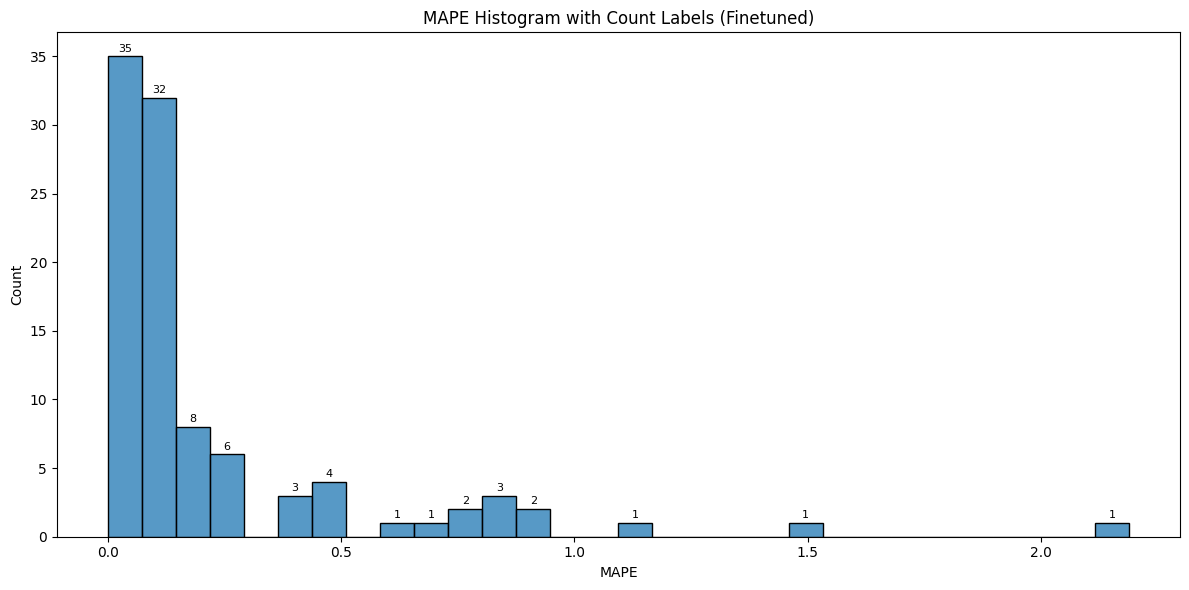

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df_best = pd.read_excel("Best_Chronos_Finetuned_Performance.xlsx")

# Split into MAPE and MAE sections (assuming first 100 rows are MAPE, next 100 are MAE)
df_mape = df_best.iloc[:100].copy()
df_mae = df_best.iloc[100:].copy()

# Take absolute value for plotting
df_mape["MAPE"] = df_mape["MAPE"].abs()
df_mae["MAE"] = df_mae["MAE"].abs()

# Mark type for later plotting
df_mape["metric"] = "MAPE"
df_mae["metric"] = "MAE"

# Combine into a long-form DataFrame for shared plotting
df_combined = pd.concat([df_mape[["time_series", "MAPE", "metric"]].rename(columns={"MAPE": "value"}),
                         df_mae[["time_series", "MAE", "metric"]].rename(columns={"MAE": "value"})],
                        ignore_index=True)

# Plot MAPE histogram with count labels
plt.figure(figsize=(12, 6))
ax = sns.histplot(data=df_combined[df_combined["metric"] == "MAPE"], x="value", bins=30)

# Add count annotations
for p in ax.patches:
    height = int(p.get_height())
    if height > 0:
        ax.annotate(str(height),
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=8, color='black', xytext=(0, 2),
                    textcoords='offset points')

plt.xlabel("MAPE")
plt.ylabel("Count")
plt.title("MAPE Histogram with Count Labels (Finetuned)")
plt.tight_layout()
plt.show()

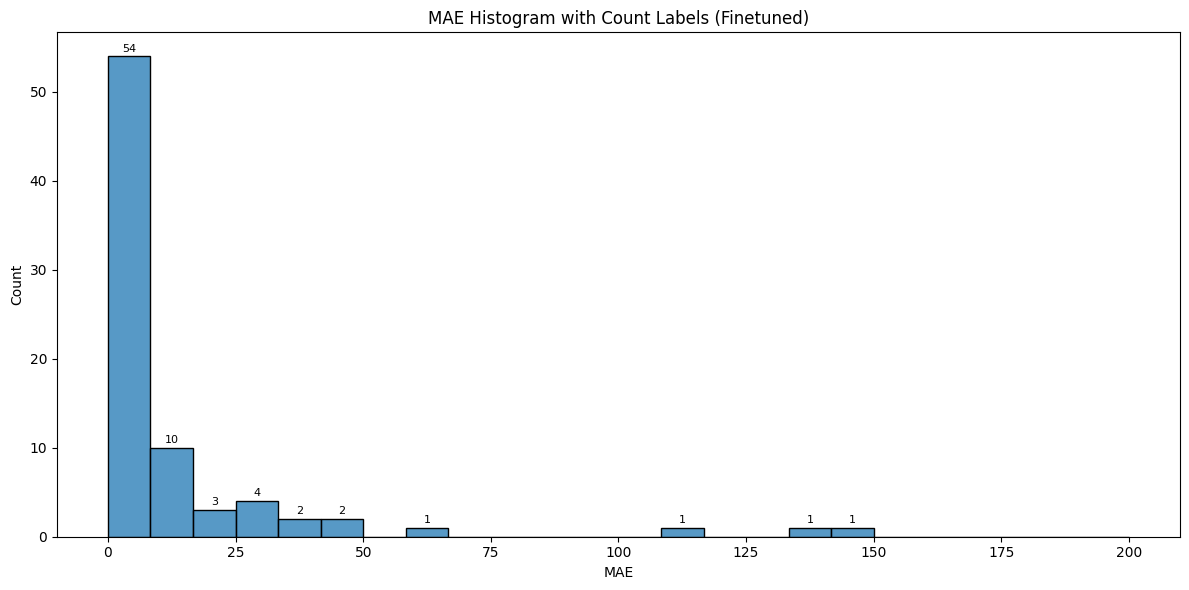

In [ ]:
# Define bin edges manually: 25 bins from 0 to 200
bin_edges = np.linspace(0, 200, 25)

plt.figure(figsize=(12, 6))
ax = sns.histplot(data=df_combined[df_combined["metric"] == "MAE"], x="value", bins=bin_edges)

# Add count annotations
for p in ax.patches:
    height = int(p.get_height())
    if height > 0:
        ax.annotate(str(height),
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=8, color='black', xytext=(0, 2),
                    textcoords='offset points')

plt.xlabel("MAE")
plt.ylabel("Count")
plt.title("MAE Histogram with Count Labels (Finetuned)")
plt.tight_layout()
plt.show()

## Explore all model result (zero-shot & finetuned)

In [3]:
%cd /content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/Chronos_results

/content/drive/MyDrive/GE_Capstone/Model Test/Forecasting/Chronos_results


In [4]:
ls

Best_Chronos_Finetuned_Performance.xlsx
Best_MAE_Per_Model.xlsx
Best_MAPE_Per_Model.xlsx
Chronos_Forecasting_Finetuned_Leaderboard.xlsx
Chronos_Forecasting_zero_shot_Leaderboard_bolt_base.xlsx
Chronos_Forecasting_zero_shot_Leaderboard_bolt_mini.xlsx
Chronos_Forecasting_zero_shot_Leaderboard_bolt_small.xlsx
Chronos_Forecasting_zero_shot_Leaderboard_bolt_tiny.xlsx


In [5]:
import pandas as pd

# Load zero-shot files and take abs values
def load_and_prepare(file, source_name):
    df = pd.read_excel(file).copy()
    df["MAPE"] = df["MAPE"].abs()
    df["MAE"] = df["MAE"].abs()
    df["source"] = source_name
    return df[["time_series", "MAPE", "MAE", "model", "source"]]

df_tiny = load_and_prepare("Chronos_Forecasting_zero_shot_Leaderboard_bolt_tiny.xlsx", "zero_shot_bolt_tiny")
df_mini = load_and_prepare("Chronos_Forecasting_zero_shot_Leaderboard_bolt_mini.xlsx", "zero_shot_bolt_mini")
df_small = load_and_prepare("Chronos_Forecasting_zero_shot_Leaderboard_bolt_small.xlsx", "zero_shot_bolt_small")
df_base = load_and_prepare("Chronos_Forecasting_zero_shot_Leaderboard_bolt_base.xlsx", "zero_shot_bolt_base")

# Load finetuned MAPE (top 100 rows) and MAE (bottom 100 rows)
df_ft = pd.read_excel("Best_Chronos_Finetuned_Performance.xlsx")
df_ft_mape = df_ft.iloc[:100].copy()
df_ft_mae = df_ft.iloc[100:].copy()
df_ft_mape["source"] = "finetune_best_MAPE"
df_ft_mae["source"] = "finetune_best_MAE"

# Select required columns
df_ft_mape = df_ft_mape[["time_series", "MAPE", "model", "source"]]
df_ft_mae = df_ft_mae[["time_series", "MAE", "model", "source"]]

# === MAPE best model selection ===
df_mape_all = pd.concat([
    df_tiny[["time_series", "MAPE", "model", "source"]],
    df_mini[["time_series", "MAPE", "model", "source"]],
    df_small[["time_series", "MAPE", "model", "source"]],
    df_base[["time_series", "MAPE", "model", "source"]],
    df_ft_mape
], ignore_index=True)

best_mape_df = df_mape_all.loc[df_mape_all.groupby("time_series")["MAPE"].idxmin()].copy()
best_mape_df.rename(columns={"MAPE": "best_MAPE", "model": "model_MAPE", "source": "source_MAPE"}, inplace=True)

# === MAE best model selection ===
df_mae_all = pd.concat([
    df_tiny[["time_series", "MAE", "model", "source"]],
    df_mini[["time_series", "MAE", "model", "source"]],
    df_small[["time_series", "MAE", "model", "source"]],
    df_base[["time_series", "MAE", "model", "source"]],
    df_ft_mae
], ignore_index=True)

best_mae_df = df_mae_all.loc[df_mae_all.groupby("time_series")["MAE"].idxmin()].copy()
best_mae_df.rename(columns={"MAE": "best_MAE", "model": "model_MAE", "source": "source_MAE"}, inplace=True)

In [6]:
best_mape_df.to_excel("Best_MAPE_Per_Model.xlsx", index=False)
best_mae_df.to_excel("Best_MAE_Per_Model.xlsx", index=False)

# from google.colab import files
# files.download("Best_MAPE_Per_Model.xlsx")
# files.download("Best_MAE_Per_Model.xlsx")

In [7]:
import pandas as pd

# Load result files
best_mape_df = pd.read_excel("Best_MAPE_Per_Model.xlsx")
best_mae_df = pd.read_excel("Best_MAE_Per_Model.xlsx")

# Count finetune_best_MAPE in MAPE results
mape_finetune_count = (best_mape_df["source_MAPE"] == "finetune_best_MAPE").sum()
mape_total = len(best_mape_df)
mape_finetune_ratio = mape_finetune_count / mape_total

# Count finetune_best_MAE in MAE results
mae_finetune_count = (best_mae_df["source_MAE"] == "finetune_best_MAE").sum()
mae_total = len(best_mae_df)
mae_finetune_ratio = mae_finetune_count / mae_total

# Print or save results
print(f"Finetune Best MAPE Count: {mape_finetune_count}/{mape_total} ({mape_finetune_ratio:.2%})")
print(f"Finetune Best MAE Count:  {mae_finetune_count}/{mae_total} ({mae_finetune_ratio:.2%})")

Finetune Best MAPE Count: 28/100 (28.00%)
Finetune Best MAE Count:  30/100 (30.00%)


In [8]:
# Describe statistics for MAPE and MAE
summary_mape = best_mape_df["best_MAPE"].describe()
summary_mae = best_mae_df["best_MAE"].describe()

# Combine results for display
summary_df = pd.DataFrame({
    "MAPE": summary_mape,
    "MAE": summary_mae
})

print(summary_df)

             MAPE            MAE
count  100.000000     100.000000
mean     0.190505    4757.107028
std      0.259042   42057.406153
min      0.000300       0.000036
25%      0.045708       1.462404
50%      0.090486       6.398056
75%      0.205692      48.331640
max      1.725102  420404.393750


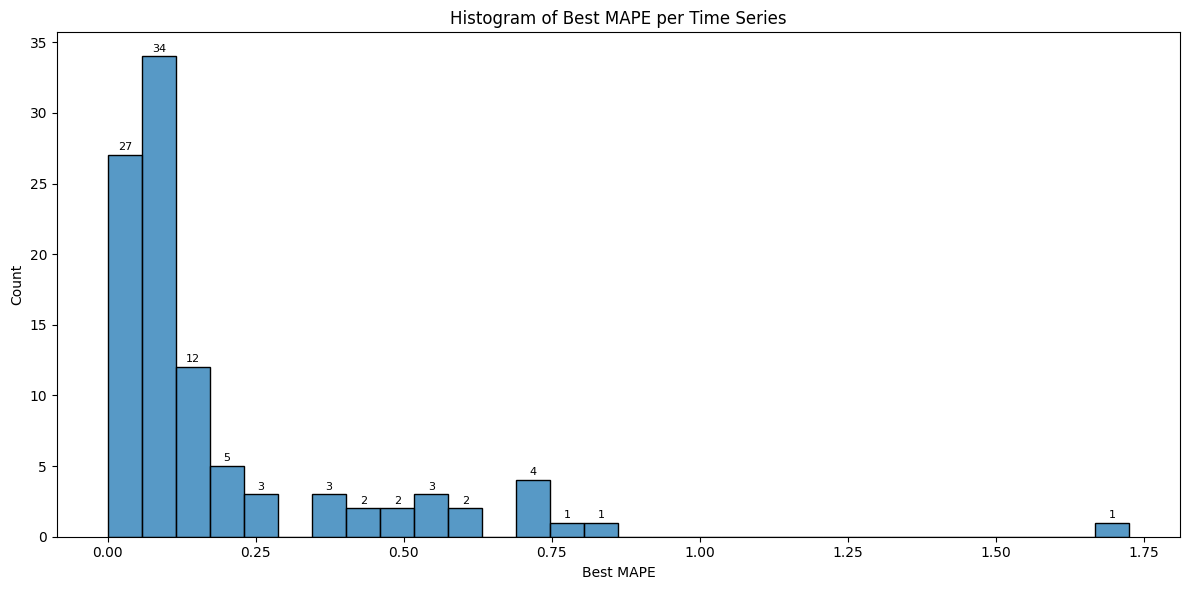

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
# Histogram for MAPE
plt.figure(figsize=(12, 6))
ax1 = sns.histplot(data=best_mape_df, x="best_MAPE", bins=30, kde=False)
for p in ax1.patches:
    height = int(p.get_height())
    if height > 0:
        ax1.annotate(str(height),
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='bottom', fontsize=8, color='black', xytext=(0, 2),
                     textcoords='offset points')
plt.xlabel("Best MAPE")
plt.ylabel("Count")
plt.title("Histogram of Best MAPE per Time Series")
plt.tight_layout()
plt.show()

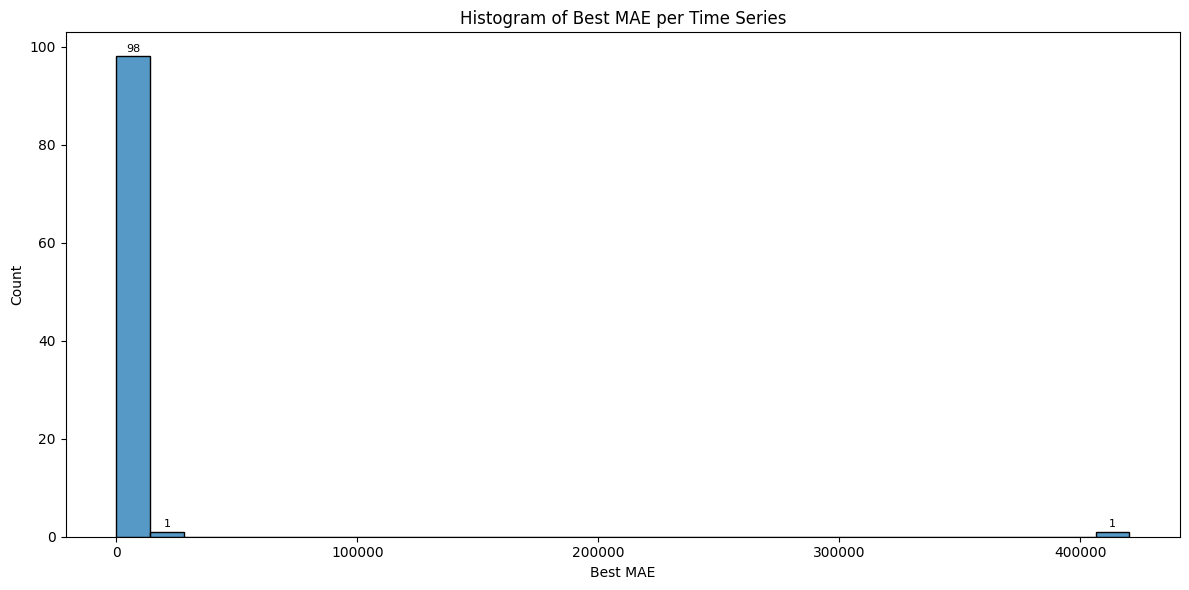

In [10]:
# Histogram for MAE
plt.figure(figsize=(12, 6))
ax2 = sns.histplot(data=best_mae_df, x="best_MAE", bins=30, kde=False)
for p in ax2.patches:
    height = int(p.get_height())
    if height > 0:
        ax2.annotate(str(height),
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='bottom', fontsize=8, color='black', xytext=(0, 2),
                     textcoords='offset points')
plt.xlabel("Best MAE")
plt.ylabel("Count")
plt.title("Histogram of Best MAE per Time Series")
plt.tight_layout()
plt.show()

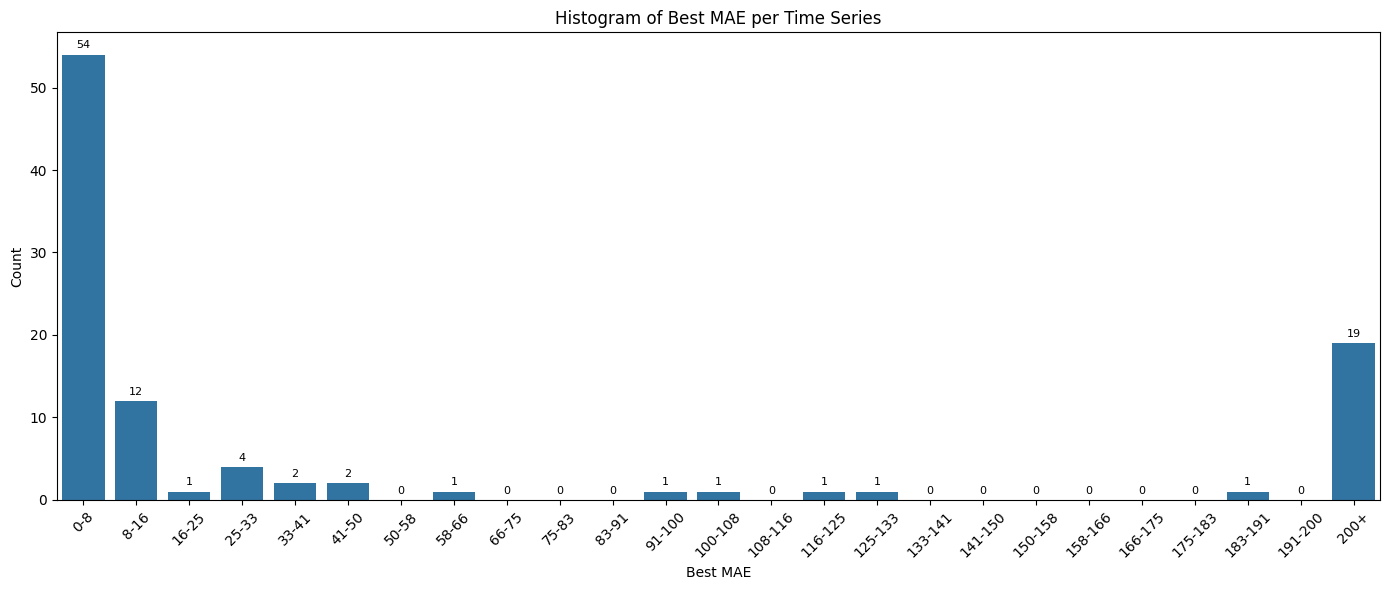

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Copy the original series
mae_values = best_mae_df["best_MAE"].copy()

# Step 2: Cap values at 200+, and create category labels manually
bin_edges = list(np.linspace(0, 200, 25))  # 24 bin edges = 24 bins
bin_labels = [f"{int(bin_edges[i])}-{int(bin_edges[i+1])}" for i in range(len(bin_edges)-1)]
bin_edges.append(np.inf)
bin_labels.append("200+")

# Step 3: Cut the values into bins with custom labels
mae_bins = pd.cut(mae_values, bins=bin_edges, labels=bin_labels, right=False, include_lowest=True)

# Step 4: Count each bin
bin_counts = mae_bins.value_counts().sort_index()

# Step 5: Plot
plt.figure(figsize=(14, 6))
ax = sns.barplot(x=bin_counts.index, y=bin_counts.values)

# Add count labels
for i, val in enumerate(bin_counts.values):
    ax.text(i, val + 0.5, str(val), ha='center', va='bottom', fontsize=8)

plt.xlabel("Best MAE")
plt.ylabel("Count")
plt.title("Histogram of Best MAE per Time Series")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()